> Igor Sorochan DSU-31

## Classification: Logistic regression. Support vector machine.

### Environment

In [25]:
import numpy as np, pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#### Loading data

In [26]:
df_raw = pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/adult.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### EDA
##### NaNs and noise

In [27]:
df_raw.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


There is some noise in data, e.g. '?'.  
Lets dig into.  
Dividing columns on data types:

In [28]:
# select all categorical columns
X_cat = df_raw.select_dtypes(include=['object'])
# select all numeric columns
X_num = df_raw.select_dtypes(include=['int64', 'float64','uint8'])

In [29]:
for col in X_cat:
  print(col.ljust(15),sorted(set(X_cat[col].values)))

workclass       ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']
education       ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']
marital-status  ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']
occupation      ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']
relationship    ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']
race            ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
gender          ['Female', 'Male']
native-country  ['?', 'Cambodia',

* `workclass, occupation, native-country` columns contain '?'
* `target` column contains only two values. So it will be binary classification problem.

Lets assume there is some meaning in the presence of symbol '?' in data.  
Foe example, if occupation and native-country ary unknown there might be greater probability of low income.

In [30]:
mask = X_cat.apply(lambda x: x.str.contains('[\s?._ ]')).any(axis=1)
rows = df_raw[mask]
rows.sample(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
27137,22,?,354351,Some-college,10,Never-married,?,Not-in-family,White,Male,0,0,40,United-States,<=50K
35031,19,?,234519,Some-college,10,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
3421,26,?,228457,11th,7,Never-married,?,Not-in-family,White,Male,0,0,40,United-States,<=50K


##### Duplicates

There are 52 duplicates.
Dropping duplicates.

In [31]:
df_raw.duplicated().value_counts()

False    48790
True        52
dtype: int64

In [32]:
df_raw.drop_duplicates(inplace= True)

##### Checking for zeros and negative values

In [33]:
mask = X_num.apply(lambda x: x < .5).any(axis=1) 
rows = df_raw[mask]
rows.sample(3)

/var/folders/qw/qq8zb5hx0w9cgzgkf9_v2sh00000gq/T/ipykernel_45673/2928447756.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4134,50,Private,245356,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
30865,56,Private,98361,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,?,>50K
12285,32,Federal-gov,228696,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Male,0,0,40,Mexico,<=50K


Zeros present at capital-* columns.  

**Lets leave data as it is.**

In [34]:
df_raw.duplicated().sum()

0

##### Visualizing input data

In [35]:
# plt.rcParams['lines.markersize'] = 1
# plt.scatter(df_raw['fnlwgt'], df_raw.age)

# "fnlwgt" stands for "final weight." The final weight is a numerical value assigned to each person in a survey or sample 
# to adjust for biases in the data collection process. The weight is used to make the sample representative of the target population,
#  so that statistical inferences can be made about the population based on the sample data. 
# The final weight is calculated using a complex formula that takes into account various factors such as the design of the survey, 
# the size of the target population, and the characteristics of the respondents. 

fig = px.histogram(df_raw, x= 'race',   color='gender', barmode= 'group')
# fig.update_traces(marker_line_width=1,marker_line_color="white")
fig.update_layout(xaxis={'categoryorder':'total descending'})

There are much more *white males* than other groups.  
We assume there is some bias here.

In [36]:
df_raw[['race', 'gender']].value_counts()

race                gender
White               Male      28703
                    Female    13011
Black               Male       2375
                    Female     2308
Asian-Pac-Islander  Male       1000
                    Female      517
Amer-Indian-Eskimo  Male        285
Other               Male        251
Amer-Indian-Eskimo  Female      185
Other               Female      155
dtype: int64

In [37]:
fig = px.histogram(df_raw, x='marital-status', color='gender', height= 700, title= "The distribution of marital-status",
        barmode= 'group', opacity=0.5 ,color_discrete_map = {'Male':'blue','Female':'red'})
fig.update_traces(marker_line_width=1,marker_line_color="white")
fig.update_layout(xaxis={'categoryorder':'total descending'})

More males were married to a civil spouse as there are far fewer women in the military.  
It's normal.

##### Feature correlations

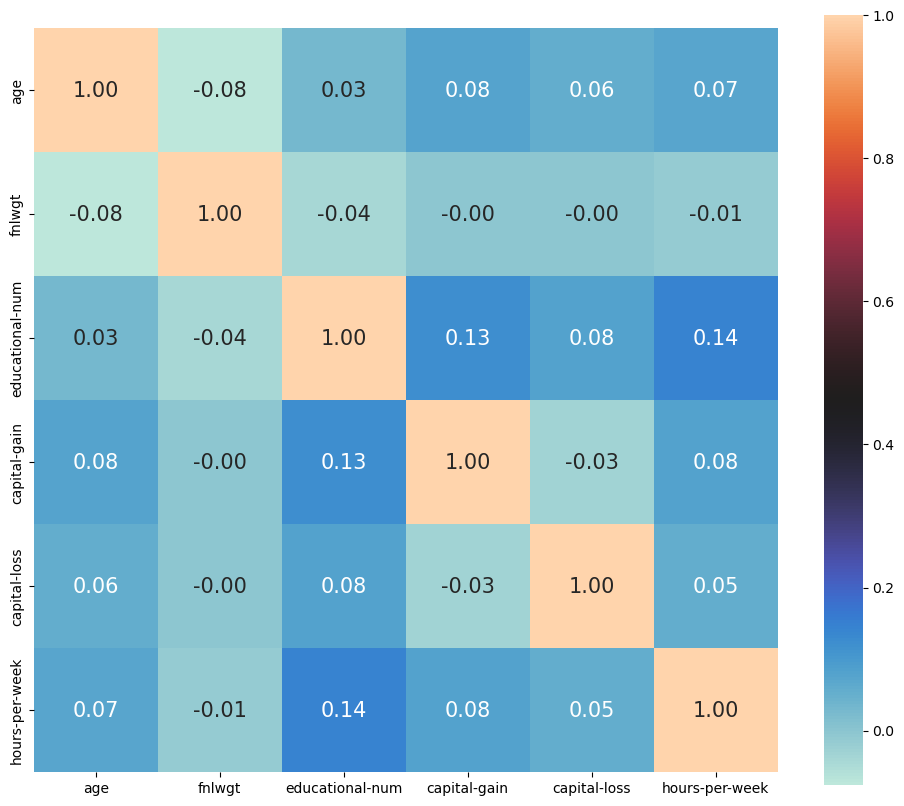

In [38]:
df_corr = df_raw.corr(numeric_only= True)
# Plotting the heatmap of correlation between features
plt.figure(figsize=(12,10))
sns.heatmap(df_corr, cbar=True, square= True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='icefire')
plt.show()

There is `no correlation` between numeric features.

### `Defining target labels and features`

In [39]:
y = df_raw['income'] # as a pd.Series
X = df_raw.drop('income', axis= 1)

Figuring out classes imbalance.

In [40]:
px.bar(y.value_counts(), width= 500, title= "Target label imbalance")

The imbalance is present, but acceptable.
Lets encode target.

In [41]:
le = LabelEncoder() 
le.fit(y)
le.classes_

array(['<=50K', '>50K'], dtype=object)

Transforming features

In [42]:
X = pd.get_dummies(X, columns= X_cat.columns.drop('income'), drop_first=True, sparse= False)
X

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,18,103497,10,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,257302,12,0,0,38,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48838,40,154374,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48839,58,151910,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48840,22,201490,9,0,0,20,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Spliting data

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

### Logistic regression pipeline

##### Default parameters

In [44]:
log_regr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
log_regr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [46]:
log_regr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [48]:
log_regr.score(X_train, y_train)

0.8528386964541914

In [50]:
log_regr.score(X_test, y_test)

0.8541709366673499

##### Looking for best parameters

In [52]:
%%time
parameters = {
              'scaler': [StandardScaler(),RobustScaler(), PowerTransformer()],
	            'logit__tol': [1e-2, 1e-3],           #Tolerance for stopping criteria.
              'logit__C': [ 7 , 5 ,  10],            # Regularization parameter.
              'logit__max_iter': [1000, 5000, 10000],  
              # 'logit__multi_class': ['ovr','multinomial'],
              'logit__n_jobs':[-1]
                }
# pipe = Pipeline([
#                   # ('scaler', StandardScaler()),
#                  ('logit', LogisticRegression())])
                 

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 19.1 µs


In [53]:
                
grid = GridSearchCV(make_pipeline(), parameters, cv=10).fit(X_train, y_train)


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:

logit_optim_score = grid.score(X_test, y_test)
print(f'Training set best score: {grid.score(X_train, y_train):2.2f}')
print(f'Test set best score: {logit_optim_score:2.3f}')

Access the best set of parameters
best_params = grid.best_params_
print('\nOptimal set of parameters:', best_params)

Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print('\nOptimal pipeline:', best_pipe)